In [347]:
import torch
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mcs
import pytorch_lightning as pl
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [238]:
T = 3000
C = 2
rs = (1, 1)
centres = ((0, 0.75), (1, 0.5))

overhang  = (1.5/16) * np.pi
theta_range = (-overhang, np.pi + overhang)

N = T // C

def circle(samples, r, centre, theta_range):
    theta = samples * np.abs(theta_range[1] - theta_range[0]) + theta_range[0]
    xs = r * np.cos(theta) + centre[0]
    ys = r * np.sin(theta) + centre[1]
    
    return xs, ys

samples = np.random.rand(C, N)
xs1, ys1 = circle(init_ys[0], rs[0], centres[0], theta_range)
xs2, ys2 = circle(init_ys[1], rs[1], centres[1], (-theta_range[1], -theta_range[0]))

# add noise to the xs and ys
sigma = 0.1
xs = np.concatenate([xs1, xs2])
ys = np.concatenate([ys1, ys2])

xs = xs + (np.random.randn(*xs.shape) * sigma)
ys = ys + (np.random.randn(*ys.shape) * sigma)

data = np.stack([xs, ys], axis=-1)
labels = np.concatenate([np.zeros(N), np.ones(N)])


In [239]:
ds = TensorDataset(torch.Tensor(data), torch.Tensor(labels).type(torch.long))
dl = DataLoader(ds, batch_size=32, shuffle=True)

In [240]:
ds[0], model(ds[0][0].unsqueeze(0))

((tensor([1.0498, 0.7528]), tensor(0)),
 tensor([[9.9991e-01, 9.3372e-05]], grad_fn=<SoftmaxBackward0>))

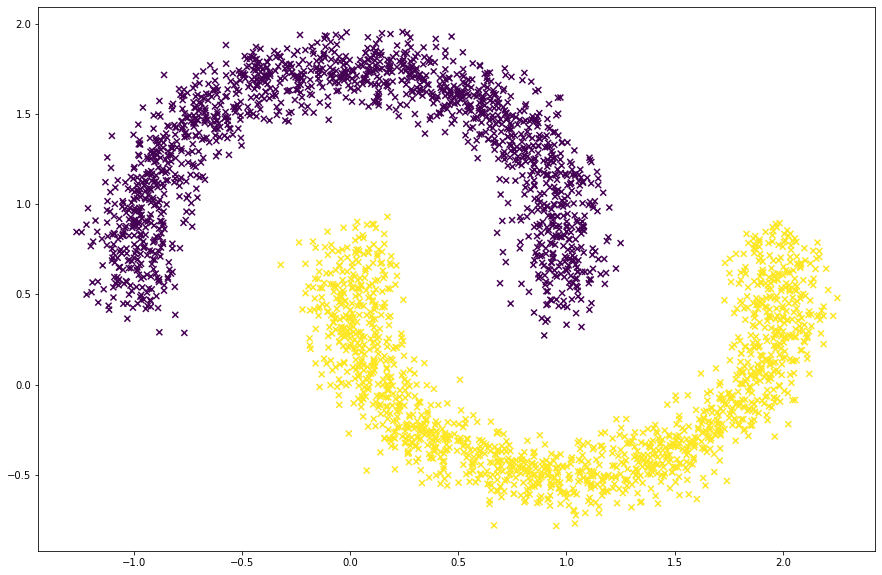

In [241]:
plt.figure(figsize=(15, 10))
plt.scatter(data[:,0], data[:,1], c=labels, marker='x')

In [926]:
class Model(pl.LightningModule):
    def __init__(self, in_channels=2, out_channels=2, nodes=64):
        super().__init__()
        self.layer1 = nn.Linear(in_channels, nodes)
        self.layer2 = nn.Linear(nodes, nodes)
        self.layer3 = nn.Linear(nodes, out_channels)
        self.lrelu = nn.LeakyReLU(0.01)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.lrelu(x)
        x = self.layer2(x)
        x = self.lrelu(x)
        x = self.layer3(x)
        x = self.softmax(x)
        return x
    
    def get_edge_strengths(self, x):
        edge_strengths = []
        edge_strengths.append(torch.abs(model.layer1.weight * x.expand(model.layer1.weight.shape)))
        x = self.layer1(x)
        x = self.lrelu(x)
        edge_strengths.append(torch.abs(model.layer2.weight * x.expand(model.layer2.weight.shape)))
        x = self.layer2(x)
        x = self.lrelu(x)
        edge_strengths.append(torch.abs(model.layer3.weight * x.expand(model.layer3.weight.shape)))
        x = self.layer3(x)
        x = self.softmax(x)
        return edge_strengths, x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        p_hat = self(x)
        loss = torch.nn.functional.cross_entropy(p_hat, y, reduction='mean')
        self.log('train_loss', loss)
        return loss

In [927]:
model = Model()

In [928]:
trainer = pl.Trainer(accelerator='cpu', max_epochs=100)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [929]:
trainer.fit(model, dl)


  | Name    | Type      | Params
--------------------------------------
0 | layer1  | Linear    | 192   
1 | layer2  | Linear    | 4.2 K 
2 | layer3  | Linear    | 130   
3 | lrelu   | LeakyReLU | 0     
4 | softmax | Softmax   | 0     
--------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [930]:
preds = []
xs = []
with torch.no_grad():
    for x, y  in dl:
        y_hat = model(x).argmax(dim=1)
        preds.append(y_hat)
        xs.append(x)
        
preds = torch.cat(preds)
xs = torch.cat(xs)

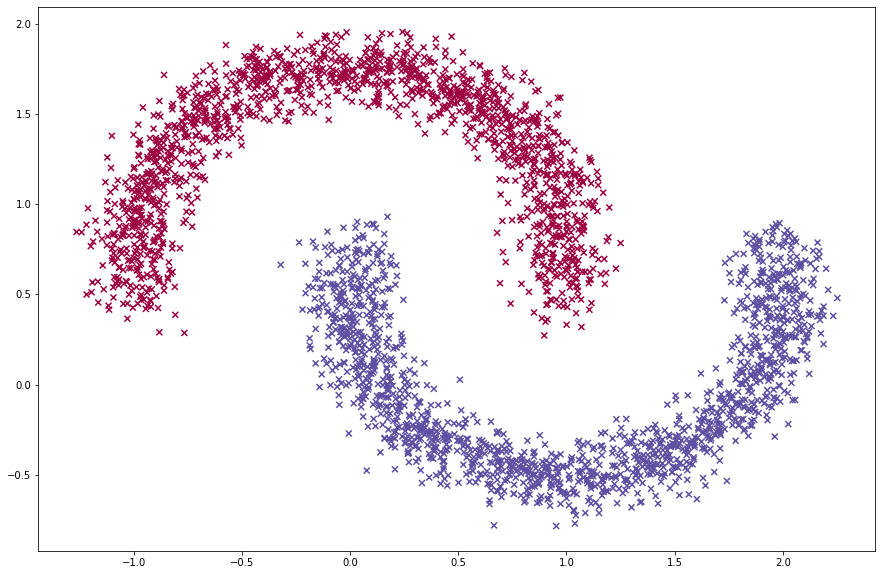

In [931]:
plt.figure(figsize=(15, 10))
plt.scatter(xs[:,0], xs[:,1], c=preds, marker='x', cmap='Spectral')

In [936]:
def get_points(P=128):
    x_range = (-2, 3)
    y_range = (-1, 2)
    x_values = np.arange(*x_range, np.abs(x_range[1] - x_range[0])/P)
    y_values = np.arange(*y_range, np.abs(y_range[1] - y_range[0])/P)

    xx, yy = np.meshgrid(x_values, y_values)

    points = torch.Tensor(np.stack([xx,yy],axis=0)).view(2,-1).T
    
    return points

In [937]:
points = get_points()

In [938]:
with torch.no_grad():
    confidences = model(points).max(dim=1)[0]

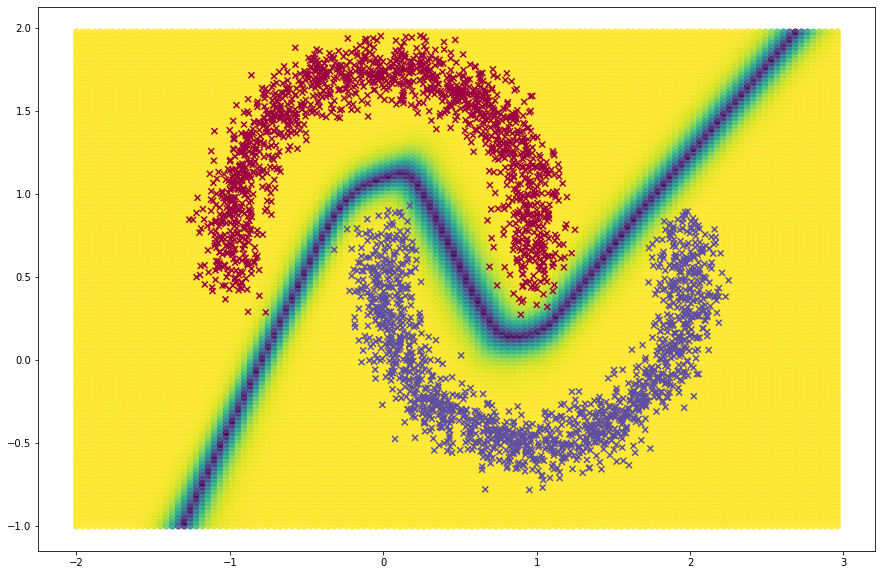

In [940]:
plt.figure(figsize=(15, 10))
plt.scatter(points[:,0], points[:,1], c=confidences, alpha=0.8)
plt.scatter(xs[:,0], xs[:,1], c=preds, marker='x', cmap='Spectral'); plt.show()

### Now build the topological uncertainty metric!

In [941]:
point = torch.Tensor([1,-0.5]).unsqueeze(0)

In [942]:
with torch.no_grad():
    edge_acts, p = model.get_edge_strengths(point)

In [943]:
p

tensor([[8.8848e-05, 9.9991e-01]])

In [944]:
layer = -1
print(edge_acts[layer].shape)
edges = edge_acts[layer]

torch.Size([2, 64])


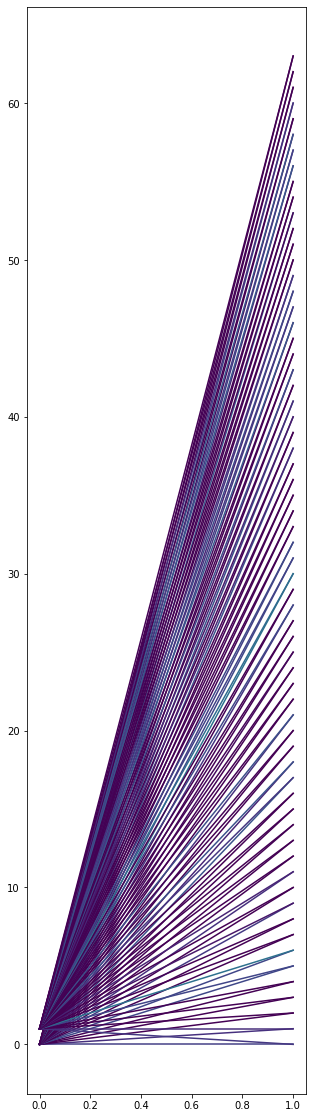

In [945]:
cmap = mcs.get_cmap('viridis')
plt.figure(figsize=(5,20))
for i in range(edges.shape[0]):
    for j in range(edges.shape[1]):
        plt.plot([0,1], [i,j], c=cmap(edges[i][j].item()))

### now get the minimum spanning tree of those edges

In [947]:
included_nodes = [torch.zeros(s) for s in edges.shape]

In [948]:
gridx = np.arange(0, edges.shape[1], 1)
gridy = np.arange(0, edges.shape[0], 1)
grid = np.meshgrid(gridx, gridy)

In [949]:
combined = torch.stack([edges, torch.Tensor(grid[0]), torch.Tensor(grid[1])], dim=-1)

In [950]:
lcomb = combined.view(-1,3)

In [951]:
sorted_edges = lcomb[lcomb[:,0].sort(descending=True)[1]]

In [952]:
included_nodes

[tensor([0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

In [953]:
#sorted_edges

In [954]:
for ed, (weight, l1, l0) in enumerate(sorted_edges):
    l1 = int(l1)
    l0 = int(l0)
    if included_nodes[0][l0] == 0 or included_nodes[1][l1] == 0:
        included_nodes[0][l0] = 1
        included_nodes[1][l1] = 1
    else:
        sorted_edges[ed] = torch.Tensor([0, l1, l0])

In [955]:
#sorted_edges

In [956]:
included_nodes

[tensor([1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]

In [957]:
torch.max(edges)

tensor(0.3762)

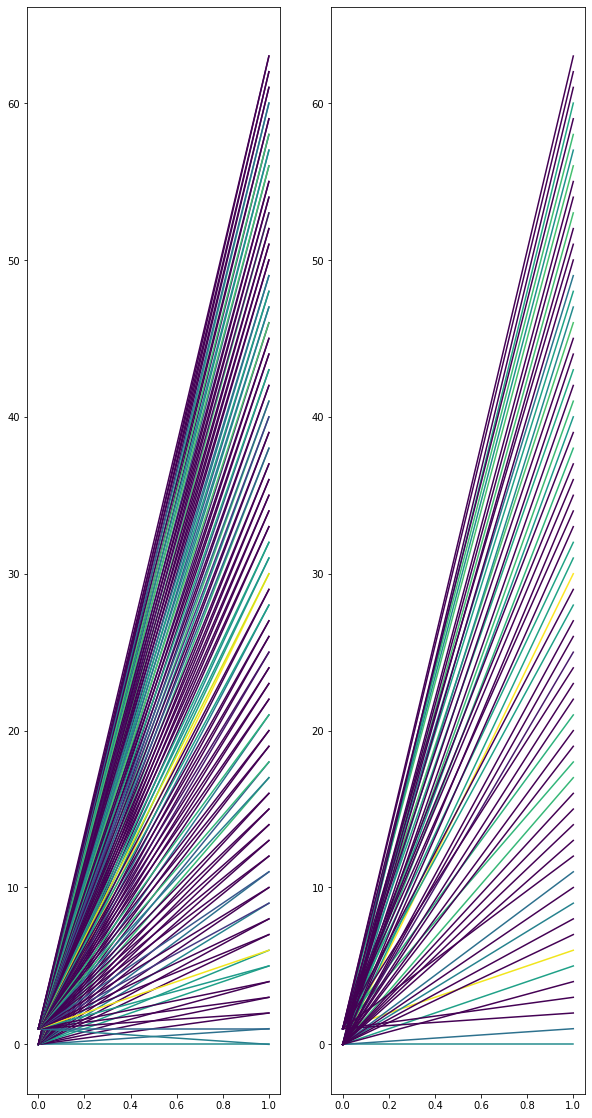

In [958]:
cmap = mcs.get_cmap('viridis')
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
max_weight = torch.max(edges).item()

for i in range(edges.shape[0]):
    for j in range(edges.shape[1]):
        plt.plot([0,1], [i,j], c=cmap(edges[i][j].item()/max_weight))
        
plt.subplot(1,2,2)
for (weight, i, j) in sorted_edges:
    if weight > 0:
        #print(weight)
        plt.plot([0,1], [j, i], c=cmap(weight.item()/max_weight))

### the above as a single function

In [1101]:
def layer_MST(edges):
    # initialize array of nodes included in the MST
    included_nodes = [torch.zeros(s) for s in edges.shape]
    
    # create a grid of weight, node i, node j
    gridx = np.arange(0, edges.shape[1], 1)
    gridy = np.arange(0, edges.shape[0], 1)
    grid = np.meshgrid(gridx, gridy)
    combined = torch.stack([edges, torch.Tensor(grid[0]), torch.Tensor(grid[1])], dim=-1)
    
    # flatten to (l0*l1*edge) * 3 mapping (3 = weight, layer 0 node, layer 1 node)
    lcomb = combined.view(-1,3)
    
    sorted_edges = lcomb[lcomb[:,0].sort(descending=True)[1]]
    
    mst_max_edges = edges.shape[0] + edges.shape[1] - 1
    
    # compute MST on sorted edges
    # edges not in the tree have their weights set to 0
    added = 0
    for ed, (weight, l1, l0) in enumerate(sorted_edges):
        l1 = int(l1)
        l0 = int(l0)
        if added == mst_max_edges:
            # efficiency. mst only has n1 + n2 - 1 edges, so don't need to compare the rest
            sorted_edges[ed:, 0] = 0.
            print(added, ed, "CHECK HOW MUCH BIGGER IS ADDED THAN ED, WHY IS IT SO SLOW?")
            break
        
        if included_nodes[0][l0] == 0 or included_nodes[1][l1] == 0:
            included_nodes[0][l0] = 1
            included_nodes[1][l1] = 1
            added += 1
        else:
            sorted_edges[ed] = torch.Tensor([0, l1, l0])
    
    
    # as I've put some 0s in the map where an edge is not used, I now need to re sort the edges
    #sorted_edges = sorted_edges[sorted_edges[:,0].sort(descending=True)[1]]
    
    sorted_edges = sorted_edges[:,[0,2,1]] # permute the ordering of the nodes to match the edges ordering 
    # (they get switched arond at some point which I should fix properly
    return sorted_edges

In [1063]:
edges.shape

torch.Size([64, 2])

In [960]:
point = torch.Tensor([0,1.75]).unsqueeze(0)

In [961]:
with torch.no_grad():
    edge_acts, p = model.get_edge_strengths(point)

I think the network reads from right to left here, not left to right, im soryr but yeah it is confusing


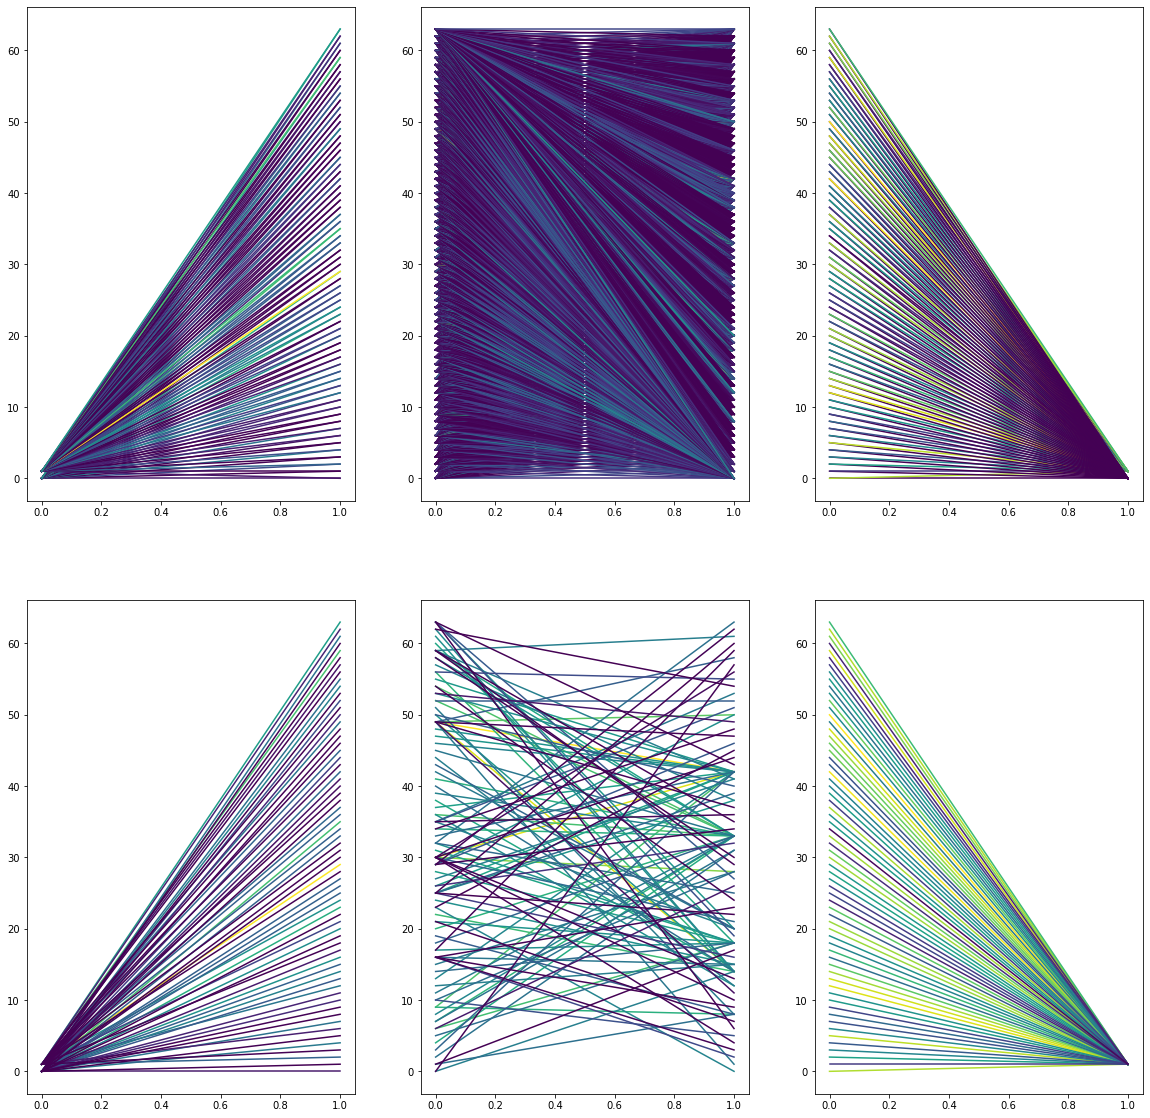

In [962]:
cmap = mcs.get_cmap('viridis')
plt.figure(figsize=(20,20))

for img_idx, l in enumerate(reversed(range(0, len(edge_acts)))):
    edges = edge_acts[l]
    sorted_edges = layer_MST(edges)
    max_weight = torch.max(edges).item()
    
    plt.subplot(2,3,1 + img_idx)
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            plt.plot([0,1], [i,j], c=cmap(edges[i][j].item()/max_weight))

    plt.subplot(2,3,4 + img_idx)
    for (weight, i, j) in sorted_edges:
        if weight > 0:
            #print(weight)
            plt.plot([0,1], [i, j], c=cmap(weight.item()/max_weight))
            
print("I think the network reads from right to left here, not left to right, im soryr but yeah it is confusing")

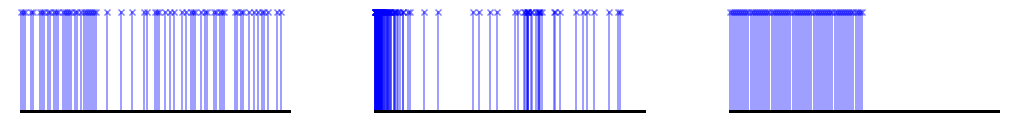

In [963]:
plt.figure(figsize=(18,2))
for img_idx, l in enumerate(reversed(range(0, len(edge_acts)))):
    edges = edge_acts[l]
    sorted_edges = layer_MST(edges)
    plt.subplot(1,3,1+img_idx)
    for i, (weight, _,_) in enumerate(sorted_edges):
        if weight > 0:
            plt.plot([i,i], [0,1], c='b', alpha=0.5)
            plt.scatter(i, 1, marker='x', c='b', alpha=0.5)
    plt.plot([0,len(sorted_edges)], [0,0], c='black', linewidth=3)
    plt.axis('off')

In [964]:
def persistence_mean(edges_array):
    included_edges = edges_array[edges_array[:,0] > 0]
    return len(included_edges) / len(edges_array)

### Compute persistence diagrams per layer per class

In [965]:
from collections import defaultdict
from tqdm import tqdm

In [687]:
pms = {0:defaultdict(lambda : []), 1:defaultdict(lambda : [])}
with torch.no_grad():
    for x, y in tqdm(ds, position=0, leave=True, ncols=150):
        edge_acts, y_hat = model.get_edge_strengths(x.unsqueeze(0))
        for l, layer_edges in enumerate(edge_acts):
            sorted_edges = layer_MST(layer_edges)
            mu = persistence_mean(sorted_edges)
            persistence_diagrams[y.item()][l].append(mu)
            

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:48<00:00,  7.35it/s]


### distance and frechet means

In [966]:
def frechet_mean(per_point_sorted_edges):
    if len(per_point_sorted_edges[0].shape) > 1:
        # extract just the weight values
        per_point_weights = [x[:,0] for x in per_point_sorted_edges]
    else:
        per_point_weights = per_point_sorted_edges
    per_point_weights = torch.stack(per_point_weights)
    mean = torch.mean(per_point_weights, dim=0)
    return mean

In [967]:
def dist(edge_ws1, edge_ws2, mst_edges, supress_warning=False):
    """
    computes the distance between a set of sorted edge weights
    mst_edges is how many edges the mst should have in it (in_nodes + out_nodes - 1)
    """
    if not supress_warning:
        print("warning, expects weights to be sorted")
    return torch.sum(torch.abs(edge_ws1 - edge_ws2) ** 2.) / mst_edges

### Topological Uncertainty

In [968]:
def TU(point_edge_weights, frechet_mean_edge_weights, supress_warning=False):
    tu = 0
    for layer, (p, fm) in enumerate(zip(point_edge_weights, frechet_mean_edge_weights)):
        tu += dist(p, fm, supress_warning)
    tu = tu / len(point_edge_weights)
    return tu

In [969]:
# get the weights for each class
weights_per_class = {0:defaultdict(lambda : []), 1:defaultdict(lambda : [])}
with torch.no_grad():
    for x, y in tqdm(ds, position=0, leave=True, ncols=150):
        edge_acts, y_hat = model.get_edge_strengths(x.unsqueeze(0))
        for l, layer_edges in enumerate(edge_acts):
            sorted_edges = layer_MST(layer_edges)
            weights_per_class[y.item()][l].append(sorted_edges[:,0])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:07<00:00,  7.01it/s]


In [970]:
nwpc = {0:defaultdict(lambda : []), 1:defaultdict(lambda : [])}
for c in nwpc.keys():
    for l in range(0, len(weights_per_class[c]), 3):
        nwpc[c][0].append(weights_per_class[c][l])
    for l in range(1, len(weights_per_class[c]), 3):
        nwpc[c][1].append(weights_per_class[c][l])
    for l in range(2, len(weights_per_class[c]), 3):
        nwpc[c][2].append(weights_per_class[c][l])

In [761]:
# compute the mean graph for the weights, per class
mean_weights_per_class = {0:[], 1:[]}
for key in nwpc.keys():
    for layer in nwpc[key].keys():
        mean_weights_per_class[key].append(frechet_mean(nwpc[key][layer]))

In [765]:
# calculate TU at a point


In [784]:
point = torch.Tensor([1,-0.5]).unsqueeze(0)

In [806]:
tus = []
with torch.no_grad():
    for point in tqdm(points, position=0, leave=True, ncols=150):
        edge_acts, p = model.get_edge_strengths(point.unsqueeze(0))
        k = p.argmax()
        
        layer_sorted_edges = [layer_MST(edges) for edges in edge_acts]
        layer_sorted_edges = [l[:,0] for l in layer_sorted_edges]
        tu = TU(layer_sorted_edges, mean_weights_per_class[k.item()], supress_warning=True)
        tus.append(tu)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 16384/16384 [37:50<00:00,  7.22it/s]


In [786]:
k

tensor(1)

In [984]:
layer_sorted_edges = [layer_MST(edges) for edges in edge_acts]

In [985]:
layer_sorted_edges = [l[:,0] for l in layer_sorted_edges]

In [986]:
TU(layer_sorted_edges, mean_weights_per_class[k.item()])

warning, expects weights to be sorted
warning, expects weights to be sorted
warning, expects weights to be sorted


tensor(0.0382)

In [808]:
tus_arr = torch.Tensor(tus)

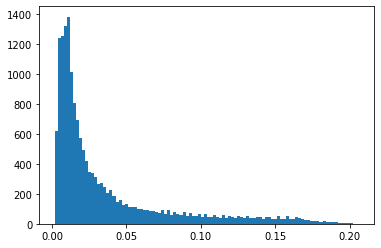

In [811]:
plt.hist(tus_arr, bins=100); plt.show()

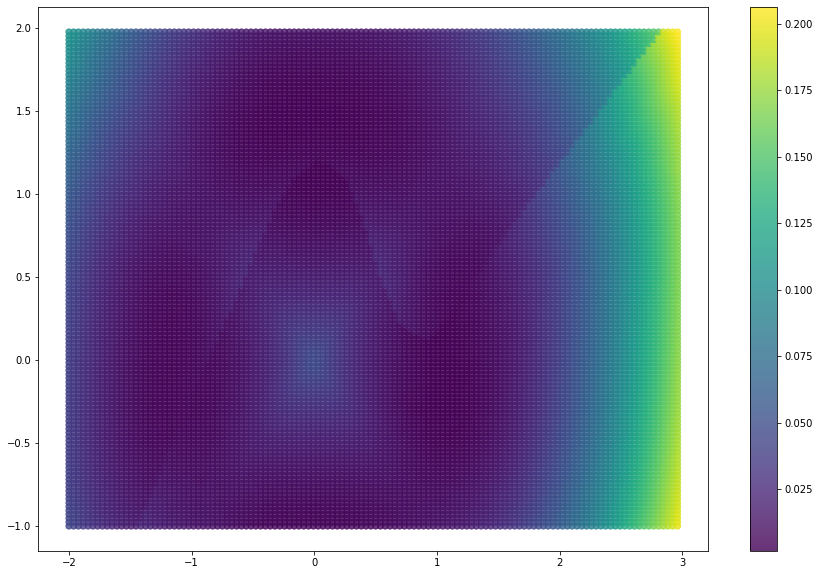

In [817]:
plt.figure(figsize=(15, 10))
plt.scatter(points[:,0], points[:,1], c=tus_arr, alpha=0.8)
plt.colorbar(),
plt.show()

### computing their average over the plain graph

In [1093]:
def set_dist(edge_ws_inp, edge_ws_set, mst_edges, supress_warning=False):
    """
    computes the distance between a set of sorted edge weights
    mst_edges is how many edges the mst should have in it (in_nodes + out_nodes - 1)
    """
    if not supress_warning:
        print("warning, expects weights to be sorted")
    # print(edge_ws_inp.shape)
    # print(torch.sum(edge_ws_inp > 0.), mst_edges)
    # print("---")
    # edge_ws_set = edge_ws_set.sort(descending=True, dim=1)[0]
    # edge_ws_inp = edge_ws_inp.sort(descending=True)[0]
    return torch.mean(torch.abs(edge_ws_set - edge_ws_inp) ** 2., dim=1) #/mst_edges

In [1094]:
def class_min_l1(edge_ws_inp, all_class_l1_weights, mst_edges):
    dists = set_dist(edge_ws_inp, all_class_l1_weights, mst_edges, supress_warning=True)
    return torch.min(dists)

In [1044]:
l0_stacked = [torch.stack(nwpc[c][0][0]) for c in nwpc.keys()]
l1_stacked = [torch.stack(nwpc[c][1][0]) for c in nwpc.keys()]
l2_stacked = [torch.stack(nwpc[c][2][0]) for c in nwpc.keys()]

In [1045]:
small_points = get_points(32)

In [1102]:
lmins = []
layer_nodes = [2,64,64,2]
mst_edges_per_layer = [layer_nodes[l] + layer_nodes[l+1] - 1 for l in range(len(layer_nodes)-1)]
with torch.no_grad():
    for point in tqdm(small_points, position=0, leave=True, ncols=150):
        edge_acts, p = model.get_edge_strengths(point.unsqueeze(0))
        k = p.argmax()
        
        layer_sorted_edges = [layer_MST(edges) for edges in edge_acts]
        layer_sorted_edges = [l[:,0] for l in layer_sorted_edges]
        point_l1_ws = layer_sorted_edges[1]
        lmin0 = class_min_l1(layer_sorted_edges[0], l0_stacked[k], mst_edges_per_layer[0])
        lmin1 = class_min_l1(layer_sorted_edges[1], l1_stacked[k], mst_edges_per_layer[1])
        lmin2 = class_min_l1(layer_sorted_edges[2], l2_stacked[k], mst_edges_per_layer[2])
        lmins.append(min(lmin0, lmin1, lmin2))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [02:45<00:00,  6.19it/s]


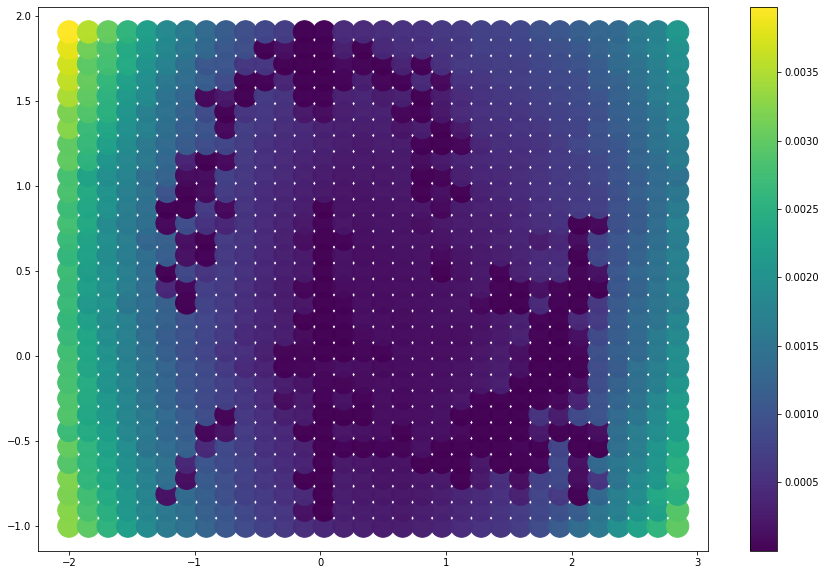

In [1104]:
plt.figure(figsize=(15, 10))
plt.scatter(small_points[:,0], small_points[:,1], c=lmins, s=500, alpha=0.99)
plt.colorbar(),
plt.show()

In [1072]:
dist2(layer_sorted_edges[0], l0_stacked[k][600])

warning, expects weights to be sorted
torch.Size([128]) torch.Size([128])


tensor(0.4271)

In [1008]:
def dist2(edge_ws1, edge_ws2, supress_warning=False):
    """
    computes the distance between a set of sorted edge weights
    """
    if not supress_warning:
        print("warning, expects weights to be sorted")
    print(edge_ws1.shape, edge_ws2.shape)
    return torch.mean(torch.abs(edge_ws1 - edge_ws2) ** 2.)

In [1076]:
layer_sorted_edges[0]

tensor([2.5373, 2.5358, 2.5075, 2.4796, 2.4414, 2.3885, 2.3819, 2.2578, 2.2515,
        2.1205, 2.1004, 2.0841, 2.0838, 2.0532, 2.0479, 2.0001, 1.9935, 1.9522,
        1.9477, 1.9435, 1.8491, 1.7441, 1.6339, 1.5958, 1.5877, 1.5832, 1.5655,
        1.5315, 1.5277, 1.5134, 1.4676, 1.4628, 1.4349, 1.4023, 1.3621, 0.0000,
        0.0000, 1.3306, 1.3085, 1.3077, 1.2931, 0.0000, 0.0000, 1.2513, 1.2488,
        0.0000, 1.2353, 1.2311, 1.2196, 1.2170, 0.0000, 1.2049, 0.0000, 1.1359,
        0.0000, 1.0991, 1.0977, 1.0885, 1.0702, 1.0684, 0.0000, 0.0000, 0.9946,
        0.9895, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [1079]:
layer_sorted_edges[0].sort(descending=True)

torch.return_types.sort(
values=tensor([2.5373, 2.5358, 2.5075, 2.4796, 2.4414, 2.3885, 2.3819, 2.2578, 2.2515,
        2.1205, 2.1004, 2.0841, 2.0838, 2.0532, 2.0479, 2.0001, 1.9935, 1.9522,
        1.9477, 1.9435, 1.8491, 1.7441, 1.6339, 1.5958, 1.5877, 1.5832, 1.5655,
        1.5315, 1.5277, 1.5134, 1.4676, 1.4628, 1.4349, 1.4023, 1.3621, 1.3306,
        1.3085, 1.3077, 1.2931, 1.2513, 1.2488, 1.2353, 1.2311, 1.2196, 1.2170,
        1.2049, 1.1359, 1.0991, 1.0977, 1.0885, 1.0702, 1.0684, 0.9946, 0.9895,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        

In [1085]:
l0_stacked[0].sort(dim=1, descending=True)[0]

tensor([[0.9367, 0.9361, 0.9256,  ..., 0.0000, 0.0000, 0.0000],
        [0.8871, 0.8866, 0.8799,  ..., 0.0000, 0.0000, 0.0000],
        [0.9421, 0.9416, 0.9310,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.8897, 0.8891, 0.8792,  ..., 0.0000, 0.0000, 0.0000],
        [0.9868, 0.9862, 0.9752,  ..., 0.0000, 0.0000, 0.0000],
        [1.0505, 1.0499, 1.0381,  ..., 0.0000, 0.0000, 0.0000]])